In [1]:
import torch
import torch_geometric
import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
import pandas
import mplhep

import sys
sys.path += ["../test"]

import train_end2end
%matplotlib inline

setGPU: Setting GPU to: 0
torch 1.4.0
torch_geometric 1.4.3


In [2]:
from collections import Counter

In [223]:
# model = "PFNet7_TTbar_14TeV_TuneCUETP8M1_cfi_gen__npar_3440145__cfg_4ff944b45d__user_jpata__ntrain_3600__lr_1e-05__1587059029"
# epoch = 45
# big_df = pandas.read_pickle("../data/{}/epoch_{}/df.pkl.bz2".format(model, epoch))
# #big_df = pandas.read_pickle("../test/TTbar_14TeV_TuneCUETP8M1_cfi.pkl.bz2")

big_df = pandas.read_pickle("../experiments/run_02/df_10.pkl.bz2")

In [224]:
v0 = big_df[(big_df["target_pid"]==211) & (big_df["pred_pid"]==211)][["target_e", "pred_e"]].values
v1 = big_df[(big_df["target_pid"]==211) & (big_df["pred_pid"]==211)][["target_eta", "pred_eta"]].values
v2 = big_df[(big_df["target_pid"]==211) & (big_df["pred_pid"]==211)][["target_phi", "pred_phi"]].values

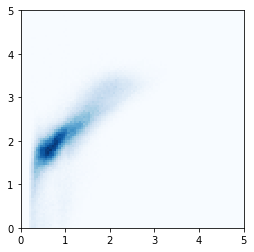

In [225]:
plt.figure(figsize=(4,4))
hist = np.histogram2d(v0[:, 0], v0[:, 1], bins=(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);

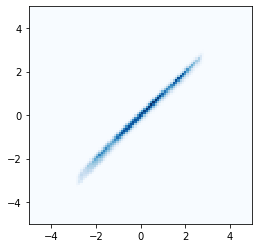

In [226]:
plt.figure(figsize=(4,4))
hist = np.histogram2d(v1[:, 0], v1[:, 1], bins=(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)))
mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);

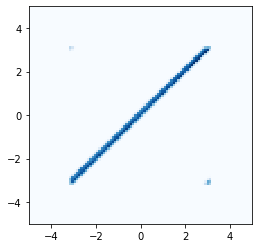

In [227]:
plt.figure(figsize=(4,4))
hist = np.histogram2d(v2[:, 0], v2[:, 1], bins=(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)))
mplhep.hist2dplot(hist[0], hist[1], hist[2], cmap="Blues", cbar=False);

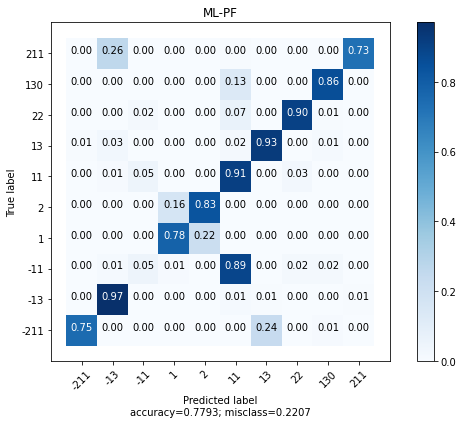

In [228]:
msk = (big_df["target_pid"] != 0) & ((big_df["pred_pid"] != 0))
confusion2 = sklearn.metrics.confusion_matrix(
    big_df["target_pid"][msk], big_df["pred_pid"][msk],
    labels=train_end2end.class_labels[1:]
)
train_end2end.plot_confusion_matrix(
    cm=confusion2, target_names=[int(x) for x in train_end2end.class_labels][1:], normalize=True
)
plt.title("ML-PF")
plt.savefig("confusion_mlpf.pdf", bbox_inches="tight")

In [198]:
bins_eta = np.linspace(-4, 4, 21)
bins_e = np.logspace(-1, 3, 21)

In [199]:
def get_eff(df, target_pid=None):
    v0 = np.sum(df==target_pid)
    return (v0 / len(df), np.sqrt(v0)/len(df))

In [200]:
def get_effs_cand_pred(pid, by, bins):
    bs = by + "_bins"
    big_df[bs] = np.searchsorted(bins, big_df[by])
    
    vals = big_df[(big_df["gen_pid"]==pid)].groupby(bs)["cand_pid"].apply(get_eff, target_pid=pid)
    xs1 = [bins[min(k, len(bins)-1)] for k in vals.keys()][:-1]
    ys1 = [v[0] for v in vals.values][:-1]
    es1 = [v[1] for v in vals.values][:-1]

    vals = big_df[(big_df["gen_pid"]==pid)].groupby(bs)["pred_pid"].apply(get_eff, target_pid=pid)
    xs2 = [bins[min(k, len(bins)-1)] for k in vals.keys()][:-1]
    ys2 = [v[0] for v in vals.values][:-1]
    es2 = [v[1] for v in vals.values][:-1]
    
    return xs1, (ys1, es1), (ys2, es2)

In [201]:
#for pid in [211, -211, 130, 22, 1, 2, -11, 11]:
for pid in [211, -211, 130, 22, 11, -11, 1, 2]:
    plt.figure(figsize=(4,4))
    xs, (ys1, es1), (ys2, es2) = get_effs_cand_pred(pid, "gen_e", bins_e)
    plt.errorbar(xs, ys1, es1, lw=1, elinewidth=1, marker=".", label="standard PF")
    plt.errorbar(xs, ys2, es2, lw=1, elinewidth=1, marker=".", label="ML-PF")
    plt.legend(frameon=False)
    plt.ylim(0, 1.5)
    plt.xscale("log")
    plt.xlabel("gen E")
    plt.ylabel("reconstruction efficiency")
    plt.title("pid={}".format(pid))
    plt.savefig("eff_pt_pid{}.pdf".format(pid), bbox_inches="tight")

    plt.figure(figsize=(4,4))
    xs, (ys1, es1), (ys2, es2) = get_effs_cand_pred(pid, "gen_eta", bins_eta)
    plt.errorbar(xs, ys1, es1, lw=1, elinewidth=1, marker=".", label="standard PF")
    plt.errorbar(xs, ys2, es2, lw=1, elinewidth=1, marker=".", label="ML-PF")
    plt.legend(frameon=False)
    plt.ylim(0, 1.5)
    plt.xlabel("gen eta")
    plt.ylabel("reconstruction efficiency")
    plt.title("pid={}".format(pid))
    plt.savefig("eff_eta_pid{}.pdf".format(pid), bbox_inches="tight")

KeyError: 'gen_e'

<Figure size 288x288 with 0 Axes>

In [64]:
def make_plot_reg(big_df, pid, pred_type, val, bins):

    m = big_df[(big_df["cand_pid"]==pid) & (big_df["{}_pid".format(pred_type)]==pid)][["cand_{}".format(val), "{}_{}".format(pred_type, val)]].values
    corr = np.corrcoef(m[:, 0], m[:, 1])[0,1]
    
    plt.figure(figsize=(4,4))
    plt.hist(m[:, 0], bins=bins, histtype="step", lw=2, label="true")
    plt.hist(m[:, 1], bins=bins, histtype="step", lw=2, label="pred")
    plt.xlabel(val)
    plt.legend(frameon=False)
    plt.savefig("pred_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")

    ngen = np.sum((big_df["cand_pid"]==pid))
    eff = np.sum((big_df["cand_pid"]==pid) & (big_df["{}_pid".format(pred_type)]==pid)) / float(np.sum((big_df["cand_pid"]==pid)))
    fake = np.sum((big_df["cand_pid"]!=pid) & (big_df["{}_pid".format(pred_type)]==pid)) / float(np.sum((big_df["{}_pid".format(pred_type)]==pid)))

    plt.figure(figsize=(4,4))
    plt.title("ngen={} corr={:.2f}\neff={:.2f} fake={:.2f}".format(ngen, corr, eff, fake))
    h = np.histogram2d(m[:, 0], m[:, 1], bins=(bins, bins))
    mplhep.hist2dplot(h[0], h[1], h[2], cmap="Blues", cbar=False)
    plt.xlabel("True {}".format(val))
    plt.ylabel("Predicted {}".format(val))
    plt.savefig("pred_corr_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")

    plt.figure(figsize=(4,4))
    var = np.abs(m[:, 1] / m[:, 0])
    var[var > 100] = 100
    var[var < 0] = 0
    plt.hist(var, bins=np.linspace(0.5, 1.5, 101))
    plt.xlabel("true {} / predicted {}".format(val, val))
    plt.title("mu={:.4f} s={:.4f}".format(np.mean(var), np.std(var)))
    plt.savefig("pred_ratio_{}_{}_{}.pdf".format(val, pred_type, pid), bbox_inches="tight")
    #plt.axvline(1.0, color="black")
    ##plt.yscale("log")

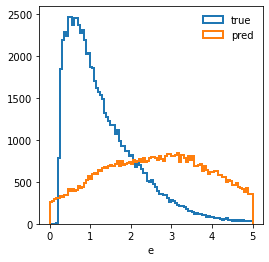

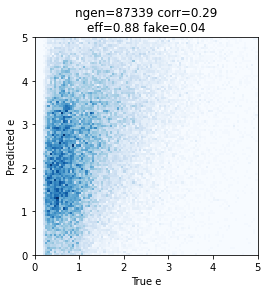

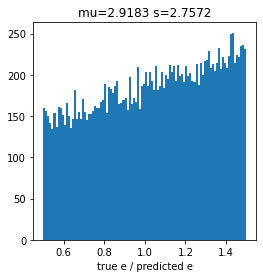

In [131]:
bins = np.linspace(0, 5, 101)
pid = 211
val = "e"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

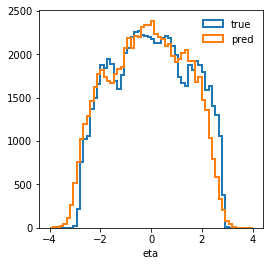

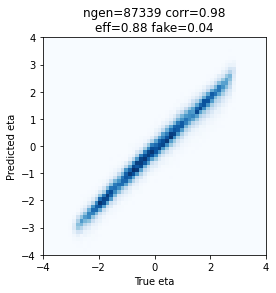

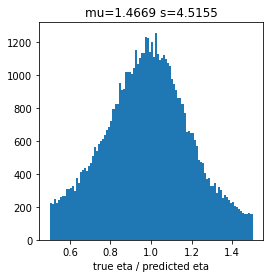

In [133]:
bins = np.linspace(-4, 4, 61)
pid = 211
val = "eta"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

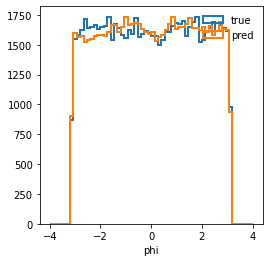

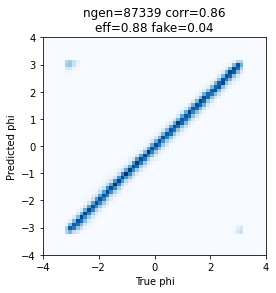

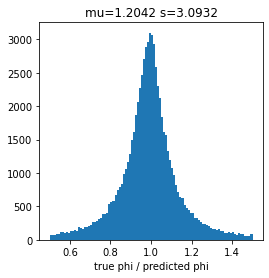

In [134]:
bins = np.linspace(-4, 4, 61)
pid = 211
val = "phi"

#make_plot_reg(big_df, pid, "cand", val, bins)
make_plot_reg(big_df, pid, "pred", val, bins)

In [ ]:
# n_preds = []
# n_trues = []
# for i in range(len(pred_ids)):
#     n_true = np.sum(true_ids[i]!=0)
#     n_pred = np.sum(pred_ids[i]!=0)
#     n_preds += [n_pred]
#     n_trues += [n_true]

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()
# plt.plot([1500,5000],[1500,5000], color="black", lw=0.5)
# plt.scatter(n_trues, n_preds, marker=".", alpha=0.5)
# plt.xlim(1500,5000)
# plt.ylim(1500,5000)
# plt.xlabel("Number of Target PF Candidates",fontsize=13)
# plt.ylabel("Number of Predicted GNN Candidates",fontsize=13)
# #plt.title("QCD Run3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# #plt.savefig("num_pred.pdf")

In [ ]:
# cms = []
# for i in range(len(pred_ids)):
#     cm = sklearn.metrics.confusion_matrix(
#         true_ids[i],
#         pred_ids[i], labels=range(len(train_end2end.class_labels))
#     )
#     cms += [cm]
# cm = sum(cms)
# cm = cm / 1000.0
# cm = np.round(cm, 1)#.astype(np.int)

In [ ]:
# train_end2end.plot_confusion_matrix(cm, [int(x) for x in train_end2end.class_labels], normalize=True)
# #plt.xlim(-0.5, 9.5)
# #plt.ylim(-0.5, 9.5)
# plt.title("Normalized Confusion Matrix (QCD Run3)")
# #plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
# #plt.tight_layout()
# plt.savefig("cm.pdf")

In [ ]:
# pm = np.concatenate(pred_momenta)
# tm = np.concatenate(true_momenta)
# ti = np.concatenate(true_ids)
# pi = np.concatenate(pred_ids)


# pm[:, 0] = np.power(10, pm[:, 0])
# tm[:, 0] = np.power(10, tm[:, 0])

In [ ]:
# plt.figure(figsize=(5, 5))

# ax = plt.axes()
# bins = np.linspace(0, 50, 100)
# h0 = plt.hist(pm[pi!=0, 0], bins=bins, histtype="step", lw=1, label="PF");
# h1 = plt.hist(tm[ti!=0, 0], bins=bins, histtype="step", lw=1, label="GNN");
# plt.yscale("log")
# plt.legend(frameon=False)
# plt.ylim(10, 1e7)

# plt.xlabel("Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("pt_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# bins = np.linspace(-4, 4, 100)
# plt.hist(pm[pi!=0, 1], bins=bins, histtype="step", lw=1);
# plt.hist(tm[ti!=0, 1], bins=bins, histtype="step", lw=1);
# plt.yscale("log")

# plt.ylim(1000, 1e6)
# plt.xlabel("Candidate $\eta$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")
# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("eta_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))

# ax = plt.axes()
# bins = np.linspace(-3, 3, 60)
# plt.hist(pm[pi!=0, 2], bins=bins, histtype="step", lw=1);
# plt.hist(tm[ti!=0, 2], bins=bins, histtype="step", lw=1);
# plt.yscale("log")
# plt.ylim(1000, 1e6)

# plt.xlabel("Candidate $\phi$ (a.u.)",fontsize=13)
# plt.ylabel("Number of Candidates",fontsize=13)
# #plt.title("QCD Run 3")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("phi_hist.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# subidx = np.where((pi!=0)&(ti!=0))[0]
# rp = np.random.permutation(range(len(subidx)))[:1000]

# plt.scatter(pm[subidx[rp], 0], tm[subidx[rp], 0], marker=".", alpha=0.5)
# plt.xlim(0,2)
# plt.ylim(0,2)
# plt.plot([0,2],[0,2], color="black")

# plt.xlabel("Target PF Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $p_{\mathrm{T}}$ (a.u.)", fontsize=13)
# #plt.title("QCD Run 3, 1000 candidates")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("pt_corr.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# plt.plot([-7, 7], [-7, 7], color="black", lw=0.5)
# plt.scatter(pm[subidx[rp], 1], tm[subidx[rp], 1], marker=".", alpha=0.5)
# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

# plt.xlabel("Target PF Candidate $\eta$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $\eta$ (a.u.)",fontsize=13)
# #plt.title("QCD Run 3, 1000 candidates")
# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("eta_corr.pdf")

In [ ]:
# plt.figure(figsize=(5, 5))
# ax = plt.axes()

# plt.plot([-5, 5], [-5, 5], color="black", lw=0.5)
# plt.scatter(pm[subidx[rp], 2], tm[subidx[rp], 2], marker=".", alpha=0.5)
# plt.xlim(-3,3)
# plt.ylim(-3,3)


# plt.xlabel("Target PF Candidate $\phi$ (a.u.)",fontsize=13)
# plt.ylabel("Predicted GNN Candidate $\phi$ (a.u.)",fontsize=13)
# #plt.title("QCD Run3, 1000 candidates")

# plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
# plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
# #plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
# plt.tight_layout()
# plt.savefig("phi_corr.pdf")

In [ ]:
# import pandas as pd
# import tqdm

# import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [8.0, 6.0]
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['legend.fontsize'] = 'large'
# mpl.rcParams['figure.titlesize'] = 'medium'

# d = full_dataset.get(1)
# d.batch = torch.zeros((len(d.x)), dtype=torch.long)
# d = d.to(device=device)
# train_end2end.data_prep(d, device=device)
# edges, cand_id_onehot, cand_momentum = model(d)
# output = edges.detach().cpu().numpy()
# d = full_dataset.get(1)
# x_data = d.x.detach().cpu().numpy()
# mask = ((x_data[:,4]==0) & (x_data[:,5]==0) & (x_data[:,6]==0) & (x_data[:,7]==0))
# good_index = np.zeros((x_data.shape[0],1,2),dtype=int)
# good_x = x_data[:,2:4].copy()                                                                            
# good_x[~mask] = x_data[~mask,2:4].copy()
# df = pd.DataFrame(good_x, columns=['eta','phi'])
# df['isTrack'] = ~mask
# row, col = d.edge_index.cpu().detach().numpy()
# y_truth = d.ycand.cpu().detach().numpy()

# min_phi = -1.25
# max_phi = 1.25
# min_eta = -1.25
# max_eta = 1.25
# extra = 1.0
# x = 'eta'
# y = 'phi'
# for plot_type in [['input'],['truth'],['output']]: 
#     k = 0
#     plt.figure(figsize=(8, 6))                        
#     for i, j in tqdm.tqdm(zip(row, col),total=len(y_truth)):
#         x1 = df[x][i]
#         x2 = df[x][j]
#         y1 = df[y][i]
#         y2 = df[y][j]
#         if (x1 < min_eta-extra or x1 > max_eta+extra) or (x2 < min_eta-extra or x2 > max_eta+extra): continue
#         if (y1 < min_phi-extra or y1 > max_phi+extra) or (y2 < min_phi-extra or y2 > max_phi+extra): continue
#         if 'input' in plot_type:
#             seg_args = dict(c='b',alpha=0.1,zorder=1)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         if 'truth' in plot_type and y_truth[k]:
#             seg_args = dict(c='r',alpha=0.8,zorder=2)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         if 'output' in plot_type:
#             seg_args = dict(c='g',alpha=output[k].item(),zorder=3)
#             plt.plot([df[x][i], df[x][j]],
#                  [df[y][i], df[y][j]], '-', **seg_args)
#         k+=1
#     cut_mask = (df[x] > min_eta-extra) & (df[x] < max_eta+extra) & (df[y] > min_phi-extra) & (df[y] < max_phi+extra)
#     cluster_mask = cut_mask & ~df['isTrack']
#     track_mask = cut_mask & df['isTrack']
#     plt.scatter(df[x][cluster_mask], df[y][cluster_mask],c='g',marker='o',s=50,zorder=4,alpha=1)
#     plt.scatter(df[x][track_mask], df[y][track_mask],c='b',marker='p',s=50,zorder=5,alpha=1)
#     plt.xlabel("Track or Cluster $\eta$",fontsize=18)
#     plt.ylabel("Track or Cluster $\phi$",fontsize=18)
#     plt.xlim(min_eta, max_eta)
#     plt.ylim(min_phi, max_phi)
#     plt.figtext(0.12, 0.90,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=20)
#     plt.figtext(0.22, 0.90,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=18)
#     plt.figtext(0.67, 0.90,'Run 3 (14 TeV)',  wrap=True, horizontalalignment='left', fontsize=18)
#     plt.savefig('graph_%s_%s_%s.pdf'%(x,y,'_'.join(plot_type)))

In [ ]:
nelem = 10000
frac_edges = 0.1
mat_size = nelem*nelem
print(mat_size * frac_edges * 4 / 1000.0 / 1000.0)
print(mat_size * 4 / 1000.0 / 1000.0)

In [ ]:
import tensorflow
import pickle
import glob
import numpy as np

In [ ]:
model = tensorflow.keras.models.load_model("../model.tf", compile=False)

In [ ]:
elem_labels = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
class_labels = [0., -211., -13., -11., 1., 2., 11.0, 13., 22., 130., 211.]

def load_data(nfiles):
    Xs = []
    ys = []
    ys_cand = []
    filelist = sorted(glob.glob("/storage/group/gpu/bigdata/particleflow/TTbar_14TeV_TuneCUETP8M1_cfi/raw/*.pkl"))
    print("Found {} input .pkl files".format(len(filelist)))
    print("loading data from {} files".format(nfiles))
    for fi in filelist[:nfiles]:
        print("loading {}".format(fi))
        data = pickle.load(open(fi, "rb"), encoding='iso-8859-1')
        for event in data:
            Xelem = event["Xelem"]
            ygen = event["ygen"]
            ycand = event["ycand"]
            Xelem[:, 0] = [int(elem_labels.index(i)) for i in Xelem[:, 0]]
            ygen[:, 0] = [int(class_labels.index(i)) for i in ygen[:, 0]]
            ycand[:, 0] = [int(class_labels.index(i)) for i in ycand[:, 0]]

            ygen = np.hstack([ygen[:, :1], ygen[:, 2:5]])
            ycand = np.hstack([ycand[:, :1], ycand[:, 2:5]])
            Xelem[np.isnan(Xelem)] = 0
            ygen[np.isnan(ygen)] = 0
            Xelem[np.abs(Xelem) > 1e4] = 0
            ygen[np.abs(ygen) > 1e4] = 0

            Xs += [Xelem.copy()]
            ys += [ygen.copy()]
            ys_cand += [ycand.copy()]

    return Xs, ys, ys_cand

def separate_prediction(y_pred):
    pred_id_onehot = y_pred[:, :len(class_labels)]
    pred_momentum = y_pred[:, len(class_labels):]
    return pred_id_onehot, pred_momentum

In [ ]:
Xs, ys, ys_cand = load_data(1)

In [ ]:
ret = model(Xs[0])

In [ ]:
a, b = separate_prediction(ret)

In [ ]:
b